In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

training_data = np.load('/content/gdrive/My Drive/ALD/training_n_data.npy')
training_std = np.load('/content/gdrive/My Drive/ALD/training_std.npy')

testing_data = np.load('/content/gdrive/My Drive/ALD/testing_n_data.npy')
testing_std = np.load('/content/gdrive/My Drive/ALD/testing_std.npy')

# Reshape to 2D Array
training_data = training_data.reshape(training_data.shape[0], 3, -1)
testing_data = testing_data.reshape(testing_data.shape[0], 3, -1)

# Convert to PyTorch tensors
training_data_tensor = torch.tensor(training_data, dtype=torch.float32).to(device)
training_std_tensor = torch.tensor(training_std, dtype=torch.float32).to(device)
testing_data_tensor = torch.tensor(testing_data, dtype=torch.float32).to(device)
testing_std_tensor = torch.tensor(testing_std, dtype=torch.float32).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(training_data_tensor, training_std_tensor)
test_dataset = TensorDataset(testing_data_tensor, testing_std_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

cuda


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size=40):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 82, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(82 * (input_size - 2), 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
criterion = nn.L1Loss()

In [ ]:
num_features = next(iter(train_loader))[0].size(-1)
[[i for i in range(0, num_features, n)] for n in range(2, 20)]

[[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38],
 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39],
 [0, 4, 8, 12, 16, 20, 24, 28, 32, 36],
 [0, 5, 10, 15, 20, 25, 30, 35],
 [0, 6, 12, 18, 24, 30, 36],
 [0, 7, 14, 21, 28, 35],
 [0, 8, 16, 24, 32],
 [0, 9, 18, 27, 36],
 [0, 10, 20, 30],
 [0, 11, 22, 33],
 [0, 12, 24, 36],
 [0, 13, 26, 39],
 [0, 14, 28],
 [0, 15, 30],
 [0, 16, 32],
 [0, 17, 34],
 [0, 18, 36],
 [0, 19, 38]]

In [ ]:
def feature_selection(train_loader, test_loader, criterion, device, epochs=300):
    results = []  # list to hold the results
    num_features = next(iter(train_loader))[0].size(-1)

    # Here are some different patterns of columns to keep
    column_patterns = [
        # The range function generates a sequence of numbers over time, and takes three arguments:
        # 'start', 'stop', and 'step'.

        list(range(0, num_features, n)) for n in range(2, 20) # For each n from 2 to 13, a list of column indices is generated.

        # Here, we start at 0 and stop before 'num_features'. 'num_features' should be set to the total number of columns.
        # 'step' defines the increment between each index in the list. We create different patterns by changing the step size.
    ]

    for pattern in column_patterns:
        print(f"Training with pattern {pattern}")

        model = CNN(len(pattern)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        for i in range(epochs):
            train_loss = 0.0
            test_loss = 0.0

            model.train()
            for b, (X_train, y_train) in enumerate(train_loader):
                # Keep only columns in the pattern
                X_train = X_train[:, :, pattern].to(device)
                y_train = y_train.to(device)

                y_pred = model(X_train)
                target = y_train.view(-1, 1)
                target = target.expand_as(y_pred)
                loss = criterion(y_pred, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            average_train_loss = train_loss / len(train_loader)

            model.eval()
            with torch.no_grad():
                for X_test, y_test in test_loader:
                    # Keep only columns in the pattern
                    X_test = X_test[:, :, pattern].to(device)
                    y_test = y_test.to(device)

                    y_val = model(X_test)
                    target = y_test.view(-1, 1)
                    target = target.expand_as(y_val)
                    loss = criterion(y_val, target)

                    test_loss += loss.item()

            average_test_loss = test_loss / len(test_loader)

            if i % (epochs//2) == 0:
                print(f'Epoch: {i}/{epochs} | Train Loss: {average_train_loss:.6f} | Test Loss: {average_test_loss:.6f}')

        with torch.no_grad():
          y_pred = model(testing_data_tensor[:, :, pattern])
          y_pred_cpu = y_pred.cpu()

          testing_std_tensor_cpu = testing_std_tensor.cpu()

          mae = mean_absolute_error(testing_std_tensor_cpu, y_pred_cpu)
          r_squared = r2_score(testing_std_tensor_cpu, y_pred_cpu)

        results.append((pattern, average_train_loss, mae, r_squared))

    return results


In [ ]:
results = feature_selection(train_loader, test_loader, criterion, device, epochs=200)

Training with pattern [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
Epoch: 0/200 | Train Loss: 0.011911 | Test Loss: 0.005962
Epoch: 100/200 | Train Loss: 0.001566 | Test Loss: 0.002134
Training with pattern [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]
Epoch: 0/200 | Train Loss: 0.014543 | Test Loss: 0.011126
Epoch: 100/200 | Train Loss: 0.001826 | Test Loss: 0.001374
Training with pattern [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
Epoch: 0/200 | Train Loss: 0.013469 | Test Loss: 0.006713
Epoch: 100/200 | Train Loss: 0.001088 | Test Loss: 0.001407
Training with pattern [0, 5, 10, 15, 20, 25, 30, 35]
Epoch: 0/200 | Train Loss: 0.018906 | Test Loss: 0.010376
Epoch: 100/200 | Train Loss: 0.001912 | Test Loss: 0.001496
Training with pattern [0, 6, 12, 18, 24, 30, 36]
Epoch: 0/200 | Train Loss: 0.029667 | Test Loss: 0.010867
Epoch: 100/200 | Train Loss: 0.001995 | Test Loss: 0.001399
Training with pattern [0, 7, 14, 21, 28, 35]
Epoch: 0/200 | Train Loss: 0.0

In [ ]:
def plot_results_MAE(results):
    patterns = [str(r[0]) for r in results]
    MAE = [r[2] for r in results]

    fig, ax = plt.subplots(figsize=(10,4))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=20)

    for i in range(len(patterns)):
      print(f"Patterns: {patterns[i]} | MAE: {MAE[i]}")

    ax.scatter(patterns, MAE)

    for i, txt in enumerate(MAE):
        if 0 <=  MAE[i] <= 0.02:
            ax.text(i,  MAE[i], str(round(txt, 4)), fontsize=8)

    ax.set_xlabel('Column Pattern')
    ax.set_ylabel('MAE')
    ax.set_ylim(0.0001, 0.004)
    plt.xticks(rotation='vertical')
    plt.show()

Patterns: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38] | MAE: 0.000778054993133992
Patterns: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39] | MAE: 0.0010178671218454838
Patterns: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36] | MAE: 0.001545551116578281
Patterns: [0, 5, 10, 15, 20, 25, 30, 35] | MAE: 0.0011192791862413287
Patterns: [0, 6, 12, 18, 24, 30, 36] | MAE: 0.0009357602684758604
Patterns: [0, 7, 14, 21, 28, 35] | MAE: 0.0006833277875557542
Patterns: [0, 8, 16, 24, 32] | MAE: 0.001131455646827817
Patterns: [0, 9, 18, 27, 36] | MAE: 0.0008969380869530141
Patterns: [0, 10, 20, 30] | MAE: 0.0007056877366267145
Patterns: [0, 11, 22, 33] | MAE: 0.0007971988525241613
Patterns: [0, 12, 24, 36] | MAE: 0.001200433704070747
Patterns: [0, 13, 26, 39] | MAE: 0.001624998520128429
Patterns: [0, 14, 28] | MAE: 0.0014445151900872588
Patterns: [0, 15, 30] | MAE: 0.0011325104860588908
Patterns: [0, 16, 32] | MAE: 0.001665559713728726
Patterns: [0, 17, 34] | MAE: 0.0012

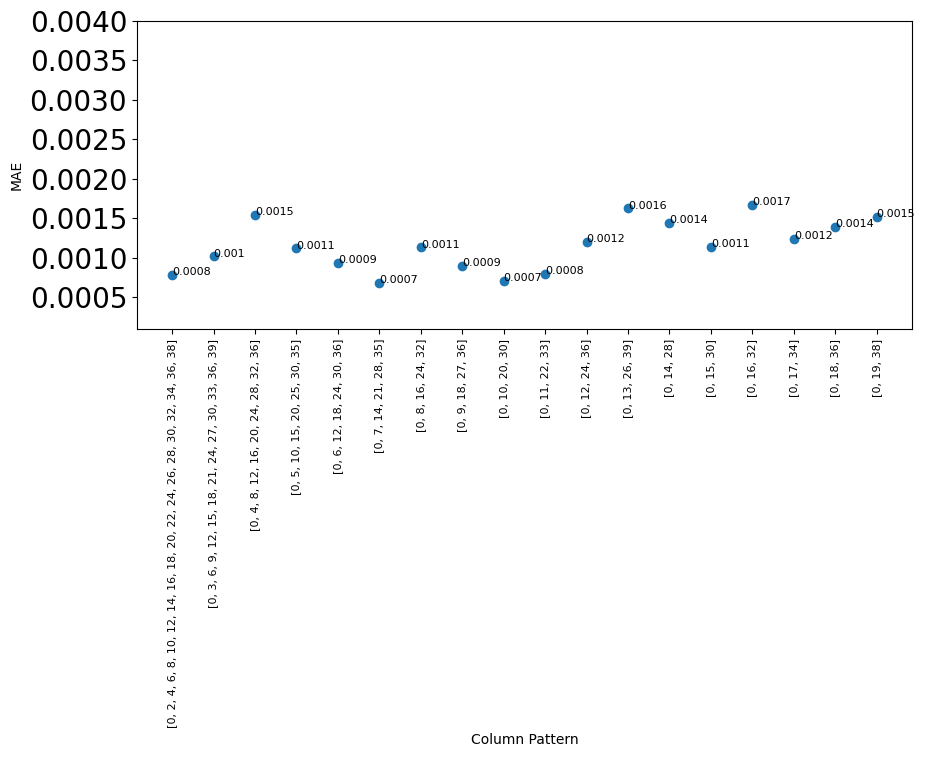

In [ ]:
plot_results_MAE(results)

In [ ]:
def plot_results_r2(results):
    patterns = [str(r[0]) for r in results]
    r2 = [r[3] for r in results]
    fig, ax = plt.subplots(figsize=(10,4))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=20)

    for i in range(len(patterns)):
      print(f"Patterns: {patterns[i]} | R-Squared: {r2[i]}")

    ax.scatter(patterns, r2)
    for i, txt in enumerate(r2):
        if 0 <= r2[i] <= 1:
            ax.text(i, r2[i], str(round(txt, 4)), fontsize=8)


    ax.set_xlabel('Column Pattern')
    ax.set_ylabel('R-Squared')
    ax.set_ylim(.975, 1)
    plt.xticks(rotation='vertical')
    plt.show()

Patterns: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38] | R-Squared: 0.9990718546128553
Patterns: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39] | R-Squared: 0.9968700730447874
Patterns: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36] | R-Squared: 0.9972952554974305
Patterns: [0, 5, 10, 15, 20, 25, 30, 35] | R-Squared: 0.9975274089004302
Patterns: [0, 6, 12, 18, 24, 30, 36] | R-Squared: 0.998429555027575
Patterns: [0, 7, 14, 21, 28, 35] | R-Squared: 0.9992233646927501
Patterns: [0, 8, 16, 24, 32] | R-Squared: 0.9972983462758326
Patterns: [0, 9, 18, 27, 36] | R-Squared: 0.9985569835789869
Patterns: [0, 10, 20, 30] | R-Squared: 0.9991529801259912
Patterns: [0, 11, 22, 33] | R-Squared: 0.9987235708916207
Patterns: [0, 12, 24, 36] | R-Squared: 0.9965757911225968
Patterns: [0, 13, 26, 39] | R-Squared: 0.990968846317936
Patterns: [0, 14, 28] | R-Squared: 0.9924017255432654
Patterns: [0, 15, 30] | R-Squared: 0.9965247475724248
Patterns: [0, 16, 32] | R-Squared: 0.994

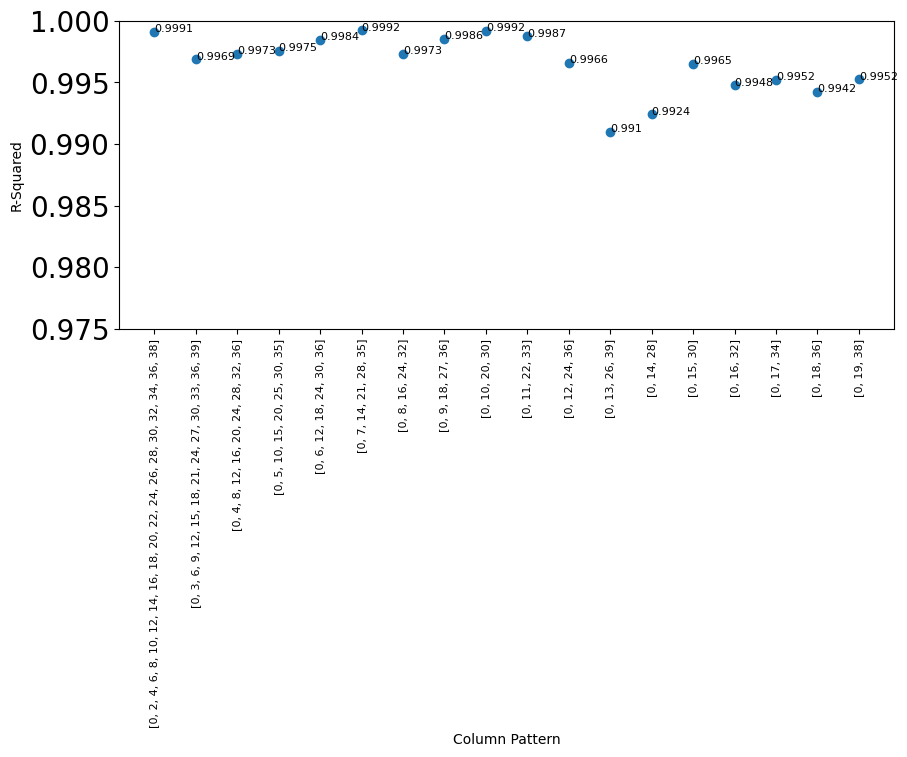

In [ ]:
plot_results_r2(results)